In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [467]:
# Read in Data
data538 = pd.read_csv('nba_elo.csv')

In [83]:
def get_post_elo(home_team, home_team_elo, away_team, away_team_elo, mov, decay, home_adv):
    
    home_post_elo = get_k(mov, home_team_elo, away_team_elo, decay)*(int(mov>0) - get_win_prob(home_team_elo, away_team_elo, home_adv)) + home_team_elo
    away_post_elo = away_team_elo + (home_team_elo - home_post_elo)
    
    return home_post_elo, away_post_elo
    
def get_win_prob(home_team_elo, away_team_elo, hfa):
    home_team_elo += hfa
    return 1.0/(1.0+(10.0**((away_team_elo-home_team_elo)/400)))

def get_k(mov, team_elo, opp_elo, decay):
    
    if mov > 0: elo_dif = team_elo-opp_elo
    else: elo_dif = opp_elo-team_elo
    
    K = 20.0*((np.abs(mov)+3.0)**.8)
    K = K/(7.5 + .006*elo_dif)
    return K*decay

In [457]:
def train_k_decay(data, elos={}, season_start_epsilon=1.0, epsilon_decay=1.0, hfa=100):
    
    epsilon = season_start_epsilon
    elo_dict = {}

    val_dict_list = []
    test_dict_list = []

    # For Each Game
    for i in range(data.shape[0]):

        # Get Game Info
        row = data.iloc[i]
        team = row.team1
        opp = row.team2
        mov = row.score1 - row.score2

        # Seasonal ELO Adjustment for Every Team
        if i > 0 and row.season != data.iloc[i-1].season:
            for k in elo_dict.keys():
                elo_dict[k] = .75*elo_dict[k] + .25*1505

            # Reset Epsilon
            epsilon = season_start_epsilon

        # If team's first game, use 538's elo to start
        if team not in elo_dict.keys():
            elo_dict[team] = row['elo1_pre']
        if opp not in elo_dict.keys():
            elo_dict[opp] = row['elo2_pre']

        # Get Pre-Game ELO Estimates
        team_pre = elo_dict[team]
        opp_pre = elo_dict[opp]

        # Adjust Epsilon Every 100 Games
        if i % 100 == 0:
            epsilon *= epsilon_decay

        # Update ELOs based on game results    
        elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, hfa)
        
    return elo_dict

def k_decay_validation_dict(data, elos={}, season_start_epsilon=1.0, epsilon_decay=1.0, hfa=100):
    
    '''
    Inputs:
     - data: Set of games to validate the ELO model on
     - elos: set of trained elos
     - val_dfs: List of DataFrames that contain ELOs for every game
     - season_start_epsilon
     - epsilon_decay
     - hfa: Home Field Advantage adjustment
     
     Outputs:
      - Row for DataFrame of Total Loss and overall Prediction Accuracy, for every combination of hyperparameters
    
    '''
    
    elo_dict = elos
    val_dict_list = []
    epsilon = season_start_epsilon

    for i in range(data.shape[0]):
        
        row = data.iloc[i]
        team = row.team1
        opp = row.team2
        mov = row.score1 - row.score2

        # Seasonal ELO Adjustment for Every Team
        if i > 0 and row.season != data.iloc[i-1].season:
            for k in elo_dict.keys():
                elo_dict[k] = .75*elo_dict[k] + .25*1505

            # Reset Epsilon
            epsilon = season_start_epsilon

        # If team's first game, use 538's elo to start
        if team not in elo_dict.keys():
            elo_dict[team] = row['elo1_pre']
        if opp not in elo_dict.keys():
            elo_dict[opp] = row['elo2_pre']

        # Get Pre-Game ELO Estimates
        team_pre = elo_dict[team]
        opp_pre = elo_dict[opp]

        # Adjust Epsilon Every 100 Games
        if i % 100 == 0:
            epsilon *= epsilon_decay

        # Update ELOs based on game results    
        elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, hfa)
        
        # Build DataFrame with Post-Game ELOs
        team_post = elo_dict[team]
        opp_post = elo_dict[opp]
        val_dict_list.append({'team1': team, 'team2': opp, 'team1_pre': team_pre, 'team2_pre': opp_pre, 'team1_post': team_post, 'team2_post': opp_post, 'MOV': mov})

    # New DataFrame of Elos Over Games in Validation Set
    val_df = pd.DataFrame(val_dict_list)
    
    preds = []
    losses = []
    outcomes = []

    # For Each Game in Validation Set
    for i in range(val_df.shape[0]):

        # Get Game Info
        row = val_df.iloc[i]
        mov = row.MOV 
        team_elo = row['team1_pre']
        opp_elo = row['team2_pre']

        # Get Predictions, Loss, and Results
        preds.append(get_win_prob(team_elo, opp_elo, hfa) > .5)
        losses.append(np.log(get_win_prob(team_elo, opp_elo, hfa) if mov > 0 else 1 - get_win_prob(team_elo, opp_elo, hfa)))
        outcomes.append(mov > 0)

    # True if Success, Otherwise False
    success_list = [preds[j] == outcomes[j] for j in range(len(preds))]

    # Make Row for DataFrame of Validation Results w/ Loss as accuracy
    return {'total_loss': np.sum(losses), 'accuracy': np.mean(success_list), 'season_start_ep': season_start_epsilon, 'epsilon_decay': epsilon_decay, 'HFA': hfa}

def test_model_dict(pre_data, data, elos={}, season_start_epsilon=1.0, epsilon_decay=1.0, hfa=100):
    '''
    Inputs: All the model stuff
    Outputs: Dictionary with model accuracy and total loss
    '''
    
    new_elos = train_k_decay(pre_data, {}, season_start_epsilon, epsilon_decay, hfa)
    
    return k_decay_validation_dict(data, new_elos, season_start_epsilon, epsilon_decay, hfa)

def fivethirtyeight_results_dict(data):
    
    # Get Predictions
    elo_preds = [get_win_prob(team_elo, opp_elo, 100) > .5 for team_elo, opp_elo in zip(data['elo1_pre'], data['elo2_pre'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(data['score1'], data['score2'])]
    
    # Get Success Rates
    elo_acc = np.mean([elo_preds[j] == outcomes[j] for j in range(len(elo_preds))])
                
    # Get Losses
    data['win_prob'] = [get_win_prob(elo1, elo2, 100) for elo1, elo2 in zip(data['elo1_pre'], data['elo2_pre'])]            
    elo_loss = np.sum([np.log(prob if outcome == 1 else 1 - prob) for prob, outcome in zip(data['win_prob'], outcomes)])
                
    return {'total_loss_538': elo_loss, 'accuracy_538': elo_acc, 'season_start_ep': 1, 'epsilon_decay': 1, 'HFA': 100}

def k_decay_elo_list(data, season_start_epsilon, epsilon_decay, hfa):
    
    elo1_list = []
    elo2_list = []
    
    epsilon = season_start_epsilon
    elo_dict = {}

    val_dict_list = []
    test_dict_list = []

    # For Each Game
    for i in range(data.shape[0]):

        # Get Game Info
        row = data.iloc[i]
        team = row.team1
        opp = row.team2
        mov = row.score1 - row.score2

        # Seasonal ELO Adjustment for Every Team
        if i > 0 and row.season != data.iloc[i-1].season:
            for k in elo_dict.keys():
                elo_dict[k] = .75*elo_dict[k] + .25*1505

            # Reset Epsilon
            epsilon = season_start_epsilon

        # If team's first game, use 538's elo to start
        if team not in elo_dict.keys():
            elo_dict[team] = row['elo1_pre']
        if opp not in elo_dict.keys():
            elo_dict[opp] = row['elo2_pre']

        # Get Pre-Game ELO Estimates
        team_pre = elo_dict[team]
        opp_pre = elo_dict[opp]
        
        # Add Elos to List
        elo1_list.append(team_pre)
        elo2_list.append(opp_pre)

        # Adjust Epsilon Every 100 Games
        if i % 100 == 0:
            epsilon *= epsilon_decay

        # Update ELOs based on game results    
        elo_dict[team], elo_dict[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, hfa)
        
    return (elo1_list, elo2_list)

def get_quantile(l, q):
    return sorted(l)[int(np.ceil((len(l)-1)*q))]
    

In [269]:
# Training, Validation, and Test Sets

START_YEAR = 2004
VALIDATION_START_YEAR = 2010
TEST_START_YEAR = 2010

train_games = data538[data538['season'] >= START_YEAR]
train_games = train_games[train_games['season'] < VALIDATION_START_YEAR]

validation_games = data538[data538['season'] >= VALIDATION_START_YEAR]
validation_games = validation_games[validation_games['season'] < TEST_START_YEAR]

pre_test_games = data538[data538['season'] >= START_YEAR]
pre_test_games = pre_test_games[pre_test_games['season'] < TEST_START_YEAR]

test_games = data538[data538['season'] >= TEST_START_YEAR]
test_games = test_games[test_games['season'] < 2019]

In [347]:
# Hyperparameters to Tune
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import STATUS_OK

# Trials object to track progress
bayes_trials = Trials()

# Algorithm
tpe_algorithm = tpe.suggest

# Define Search Space
space = {
    'season_start_epsilon': hp.uniform('season_start_epsilon', .7, 1.8),
    'epsilon_decay': hp.uniform('epsilon_decay', .6, 1.2),
    'hfa': hp.quniform('h', 30, 130, 1)
}

MAX_EVALS = 400
accuracy_metric = 'total_loss' # or 'accuracy' for pure game prediction

def objective(params):
    
    start_ep = params['season_start_epsilon']
    ep_decay = params['epsilon_decay']
    h = params['hfa']
    
    new_elos = train_k_decay(train_games, elos={}, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)
    dic = k_decay_validation_dict(test_games, elos=new_elos, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)
    new_dic = {'loss': -1*dic[accuracy_metric], 'season_start_epsilon': start_ep, 'epsilon_decay': ep_decay, 'hfa': h, 'status': STATUS_OK}
    return new_dic

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

best

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in log


{'epsilon_decay': 0.9345747516220297,
 'h': 76.0,
 'season_start_epsilon': 1.3644233059720572}

In [417]:
print("season_start_k_multiplier:", np.round(best['season_start_epsilon'], 4))
print("k_decay_rate:", np.round(best['epsilon_decay'], 4))
print("HFA:", best['h'])

season_start_k_multiplier: 1.3644
k_decay_rate: 0.9346
HFA: 76.0


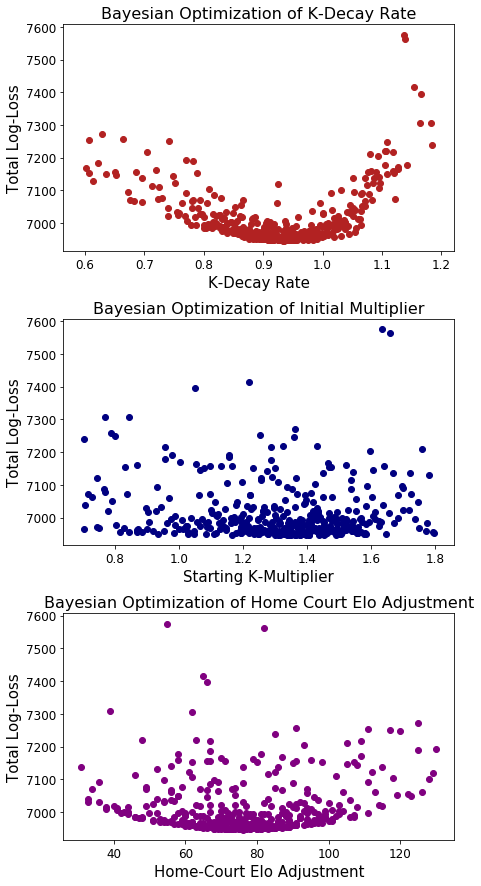

In [361]:
# Show Trial Loss Over Time
trials = list(bayes_trials)
losses = []
hfas = []
start_eps = []
ep_decs = []

for trial in trials:
    result = trial['result']
    if result['loss'] < 11000:
        losses.append(result['loss'])
        hfas.append(result['hfa'])
        start_eps.append(result['season_start_epsilon'])
        ep_decs.append(result['epsilon_decay'])
    
fig, axes = plt.subplots(3,1,figsize=(7,15))
fig.subplots_adjust(hspace=.3)

for ax in axes:
    ax.set_ylabel('Total Log-Loss', fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

axes[0].scatter(ep_decs, losses, color='firebrick')
axes[0].set_xlabel('K-Decay Rate', fontsize=15)
axes[0].set_title('Bayesian Optimization of K-Decay Rate', fontsize=16)

axes[1].scatter(start_eps, losses, color='navy')
axes[1].set_xlabel('Starting K-Multiplier', fontsize=15)
axes[1].set_title('Bayesian Optimization of Initial Multiplier', fontsize=16)

axes[2].scatter(hfas, losses, color='purple')
axes[2].set_xlabel('Home-Court Elo Adjustment', fontsize=15)
axes[2].set_title('Bayesian Optimization of Home Court Elo Adjustment', fontsize=16)

plt.savefig('bayes_opt2.png')
plt.show()

In [350]:
# Get Accuracy for the 'Best' Model Hyperparameters
start_ep = best['season_start_epsilon']
ep_decay = best['epsilon_decay']
h = best['h']

old_model_start_ep = 1.403857708071705
old_model_ep_decay = 0.9362537924997516
old_model_hfa = 88.0

#start_ep = old_model_start_ep
#ep_decay = old_model_ep_decay
#h = old_model_hfa

new_elos = train_k_decay(train_games, elos={}, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)
k_decay_validation_dict(test_games, elos=new_elos, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)

{'HFA': 76.0,
 'accuracy': 0.67325963033339087,
 'epsilon_decay': 0.9345747516220297,
 'season_start_ep': 1.3644233059720572,
 'total_loss': -6946.3544498028014}

In [351]:
fivethirtyeight_results_dict(test_games)

{'HFA': 100,
 'accuracy_538': 0.67153221627224047,
 'epsilon_decay': 1,
 'season_start_ep': 1,
 'total_loss_538': -6973.8660894852956}

In [352]:
test_model_dict(pre_test_games, test_games, {}, start_ep, ep_decay, h)

{'HFA': 76.0,
 'accuracy': 0.67325963033339087,
 'epsilon_decay': 0.9345747516220297,
 'season_start_ep': 1.3644233059720572,
 'total_loss': -6946.3544498028014}

In [353]:
fivethirtyeight_results_dict(test_games)

{'HFA': 100,
 'accuracy_538': 0.67153221627224047,
 'epsilon_decay': 1,
 'season_start_ep': 1,
 'total_loss_538': -6973.8660894852956}

In [354]:
# Get List of Elos
df = data538[data538['season']>=TEST_START_YEAR]
df = df[df['season']<2019]

l1, l2 = k_decay_elo_list(df, start_ep, ep_decay, h)
df['k_decay_elo1'] = l1
df['k_decay_elo2'] = l2

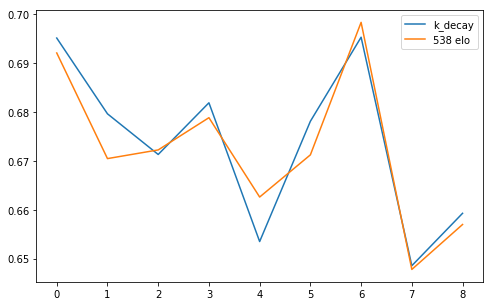

In [415]:
elo_preds = []
elo_538_preds = []
elo_accs = []
elo_538_accs = []

for year in df.season.unique():

    # Trim to the Given Season
    trim = df[df['season']==year]
    
    # Get Predictions
    elo_preds = [get_win_prob(team_elo, opp_elo, h) > .5 for team_elo, opp_elo in zip(trim['k_decay_elo1'], trim['k_decay_elo2'])]
    elo_538_preds = [get_win_prob(team_elo, opp_elo, h) > .5 for team_elo, opp_elo in zip(trim['elo1_pre'], trim['elo2_pre'])]
    #carm_elo_538_preds = [get_win_prob(team_elo, opp_elo, h) > .5 for team_elo, opp_elo in zip(trim['carm_elo1_pre_538'], trim['carm_elo2_pre_538'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(trim['score1'], trim['score2'])]
    
    # Get Success Rates
    elo_accs.append(np.mean([elo_preds[j] == outcomes[j] for j in range(len(elo_preds))]))
    elo_538_accs.append(np.mean([elo_538_preds[j] == outcomes[j] for j in range(len(elo_538_preds))]))
    #carm_elo_538_accs.append(np.mean([carm_elo_538_preds[j] == outcomes[j] for j in range(len(carm_elo_538_preds))]))
    
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(elo_accs, label='k_decay')
ax.plot(elo_538_accs, label='538 elo')

ax.legend()
plt.show()

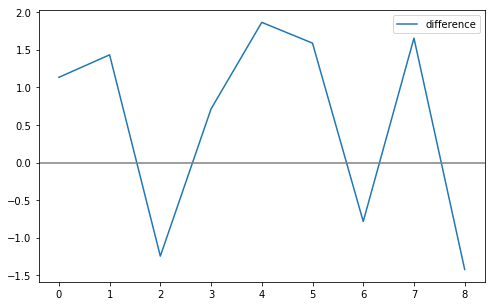

In [408]:
elo_preds = []
elo_538_preds = []
all_elo_losses = []
all_elo_538_losses = []
elo_losses = []
elo_538_losses = []

for year in df.season.unique():
    
    # Trim to the Given Season
    trim = df[df['season']==year]
    
    # Get Predictions
    elo_preds = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['k_decay_elo1'], trim['k_decay_elo2'])]
    elo_538_preds = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['elo1_pre'], trim['elo2_pre'])]
    #carm_elo_538_preds = [get_win_prob(team_elo, opp_elo, h) > .5 for team_elo, opp_elo in zip(trim['carm_elo1_pre_538'], trim['carm_elo2_pre_538'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(trim['score1'], trim['score2'])]
    
    # Get Success Rates
    elo_losses.append(np.sum([np.log(get_win_prob(team_elo, opp_elo, h) if outcome == 1 else 1 - get_win_prob(team_elo, opp_elo, h)) for outcome, team_elo, opp_elo in zip(outcomes, trim['k_decay_elo1'], trim['k_decay_elo2'])]))
    elo_538_losses.append(np.sum([np.log(get_win_prob(team_elo, opp_elo, h) if outcome == 1 else 1 - get_win_prob(team_elo, opp_elo, h)) for outcome, team_elo, opp_elo in zip(outcomes, trim['elo1_pre'], trim['elo2_pre'])]))
    #carm_elo_538_accs.append(np.mean([carm_elo_538_preds[j] == outcomes[j] for j in range(len(carm_elo_538_preds))]))
    

difs = [elo_losses[i] - elo_538_losses[i] for i in range(len(elo_losses))]

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(difs, label='difference')
#ax.plot(elo_538_losses, label='538 elo')

ax.axhline(y=0, color='grey')

ax.legend()
plt.show()

In [357]:
print(np.sum(elo_losses[-5:]))
print(np.sum(elo_538_losses[-5:]))

-3977.3007063
-3980.20501186


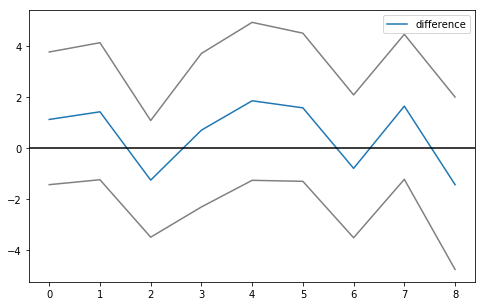

In [358]:
# Bootstrap Elo Losses
elo_losses = []
elo_538_losses = []
loss_upper = []
loss_list = []
loss_lower = []

for year in df.season.unique():
    
    # Trim to the Given Season
    trim = df[df['season']==year]
    
    win_probs = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['k_decay_elo1'], trim['k_decay_elo2'])]
    win_probs_538 = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['elo1_pre'], trim['elo2_pre'])]
    
    # Get Outcomes
    outcomes = [s1 > s2 for s1, s2 in zip(trim['score1'], trim['score2'])]
    
    # Get Predictions
    elo_losses = [np.log(prob if outcome == 1 else 1 - prob) for prob, outcome in zip(win_probs, outcomes)]
    elo_538_losses = [np.log(prob if outcome == 1 else 1 - prob) for prob, outcome in zip(win_probs_538, outcomes)]
    #carm_elo_538_preds = [get_win_prob(team_elo, opp_elo, h) > .5 for team_elo, opp_elo in zip(trim['carm_elo1_pre_538'], trim['carm_elo2_pre_538'])]
    
    # Record Loss Difference
    loss_list.append(np.sum(elo_losses)-np.sum(elo_538_losses))
    
    # BootStrap
    
    bs_loss_dif_list = []
    
    for n in range(5000):
        # Bootstrap Sample
        indices = np.random.choice([i for i in range(len(elo_losses))], size=len(elo_losses), replace=True)

        # Get Total Loss Difference for Bootstrap Sample
        bs_elo_losses = [elo_losses[index] for index in indices]
        bs_elo_losses_538 = [elo_538_losses[index] for index in indices]
        
        bs_loss_dif_list.append(np.sum(bs_elo_losses) - np.sum(bs_elo_losses_538))
        
    loss_upper.append(get_quantile(bs_loss_dif_list, .975))
    loss_lower.append(get_quantile(bs_loss_dif_list, .025))

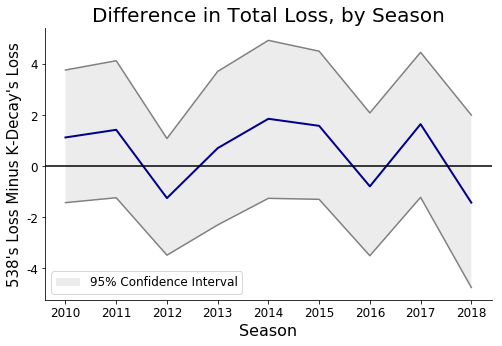

In [416]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(loss_list, color='darkblue', linewidth=2.0)
ax.plot(loss_upper, color='grey')
ax.plot(loss_lower, color='grey')

ax.fill_between(range(len(loss_list)), loss_list, loss_lower, facecolor='gray', alpha=0.15, label='95% Confidence Interval')
ax.fill_between(range(len(loss_list)), loss_list, loss_upper, facecolor='gray', alpha=0.15)

ax.set_xticklabels(range(2009, 2019), fontsize=12)
ax.set_yticklabels(range(-6, 5, 2), fontsize=12)

ax.set_xlabel('Season', fontsize=16)
ax.set_ylabel("538's Loss Minus K-Decay's Loss", fontsize=15)
ax.set_title('Difference in Total Loss, by Season', fontsize=20)

ax.axhline(y=0, color='black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

#ax.grid()
ax.legend(fontsize=12)
#plt.savefig('Loss_Difference_Intervals.png')
plt.show()

In [410]:
np.sum(elo_losses)

-6944.949941819561

In [411]:
np.sum(elo_538_losses)

-6949.8903320804338

In [413]:
elo_aic = 2*3 + -2*np.sum(elo_losses)
elo_aic

13895.899883639122

In [414]:
elo_538_aic = 2*2 + -2*np.sum(elo_538_losses)
elo_538_aic

13903.780664160868

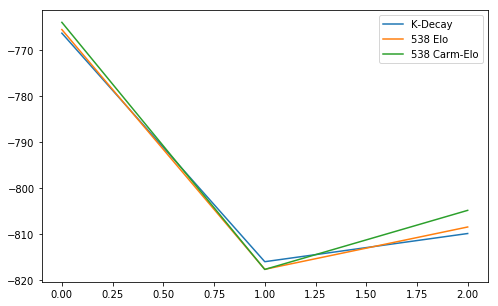

In [420]:
elo_preds = []
elo_538_preds = []
carm_elo_538_losses = []
elo_losses = []
elo_538_losses = []

for year in df.season.unique():
    
    if year >= 2016:
        # Trim to the Given Season
        trim = df[df['season']==year]

        # Get Predictions
        #elo_preds = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['k_decay_elo1'], trim['k_decay_elo2'])]
        #elo_538_preds = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['elo1_pre'], trim['elo2_pre'])]
        #carm_elo_538_preds = [get_win_prob(team_elo, opp_elo, h) for team_elo, opp_elo in zip(trim['carm_elo1_pre_538'], trim['carm_elo2_pre_538'])]

        # Get Outcomes
        outcomes = [s1 > s2 for s1, s2 in zip(trim['score1'], trim['score2'])]

        # Get Success Rates
        elo_losses.append(np.sum([np.log(get_win_prob(team_elo, opp_elo, h) if outcome == 1 else 1 - get_win_prob(team_elo, opp_elo, h)) for outcome, team_elo, opp_elo in zip(outcomes, trim['k_decay_elo1'], trim['k_decay_elo2'])]))
        elo_538_losses.append(np.sum([np.log(get_win_prob(team_elo, opp_elo, h) if outcome == 1 else 1 - get_win_prob(team_elo, opp_elo, h)) for outcome, team_elo, opp_elo in zip(outcomes, trim['elo1_pre'], trim['elo2_pre'])]))
        carm_elo_538_losses.append(np.sum([np.log(get_win_prob(team_elo, opp_elo, h) if outcome == 1 else 1 - get_win_prob(team_elo, opp_elo, h)) for outcome, team_elo, opp_elo in zip(outcomes, trim['carm-elo1_pre'], trim['carm-elo2_pre'])]))
    

difs = [elo_losses[i] - elo_538_losses[i] for i in range(len(elo_losses))]

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.plot(elo_losses, label='K-Decay')
ax.plot(elo_538_losses, label='538 Elo')
ax.plot(carm_elo_538_losses, label='538 Carm-Elo')
#ax.plot(elo_538_losses, label='538 elo')

#ax.axhline(y=0, color='grey')

ax.legend()
plt.show()

In [461]:
# Get Team Rankings
teams = []
elos = []
teams_538 = []
elos_538 = []

# Read in Data Again
nba_data = pd.read_csv('nba_elo.csv')

all_data = nba_data[nba_data['season']>=2004]
all_data = all_data[all_data['season']<2019]

games_2019 = data538[data538['season']==2019]

# Divide 2019 Games Into 'Played' and 'Not Played'
played = games_2019[~np.isnan(games_2019.score1)]
not_played = games_2019[np.isnan(games_2019.score1)]    

ELO_DICT = train_k_decay(all_data, elos={}, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)

epsilon = start_ep

# Run Decay-ELO Model Through Played Games
for i in range(played.shape[0]):

    # Get Game Info
    row = played.iloc[i]
    team = row.team1
    opp = row.team2
    mov = row.score1 - row.score2
    
    # Get Pre-Game ELO Estimates
    team_pre = ELO_DICT[team]
    opp_pre = ELO_DICT[opp]

    # Adjust Epsilon Every 100 Games
    if i % 100 == 0:
        epsilon *= ep_decay
        
    # Update ELOs based on game results    
    ELO_DICT[team], ELO_DICT[opp] = get_post_elo(team, team_pre, opp, opp_pre, mov, epsilon, h)

for k, v in ELO_DICT.items():
    teams.append(k)
    elos.append(v)
    
# Get 538's Rankings
elo_538_dict = {}
for i in range(played.shape[0]-1, -1, -1):
    
    row = played.iloc[i]
    
    team = row.team1
    opp = row.team2
    team_elo = row['elo1_post']
    opp_elo= row['elo2_post']
    
    if team not in elo_538_dict.keys(): elo_538_dict[team] = team_elo
    if opp not in elo_538_dict.keys(): elo_538_dict[opp] = opp_elo
        
    if len(elo_538_dict.keys()) == 30: break
        
for k, v in elo_538_dict.items():
    teams_538.append(k)
    elos_538.append(v)
    
elos_norm = (elos-min(elos))/(max(elos)-min(elos))
elos_538_norm = (elos_538-min(elos_538))/(max(elos_538)-min(elos_538))

# Re-Make Dictionaries for DataFrame
dict_list = []
for t, e in zip(teams, elos_norm):
    d = {'team': t, 'elo_norm': e}
    dict_list.append(d)

decay_elos = pd.DataFrame(dict_list)

dict_list = []
for t, e in zip(teams_538, elos_538_norm):
    d = {'team': t, 'elo_norm': e}
    dict_list.append(d)
    
nate_elos = pd.DataFrame(dict_list)

In [462]:
# Remove Unnecessary Teams From decay_elos
removables = []
for i in range(decay_elos.shape[0]):
    if decay_elos['team'][i] not in list(nate_elos['team']):
        removables.append(i)
decay_elos = decay_elos.drop(decay_elos.index[removables]).reset_index(drop=True)

In [463]:
# Put All Into One DataFrame
nate_list = []
for i in range(decay_elos.shape[0]):
    team = decay_elos.loc[i][1]
    for j in range(nate_elos.shape[0]):
        if nate_elos.loc[j][1] == team:
            nate_list.append(nate_elos.loc[j][0])
decay_elos['elo_538_norm'] = nate_list

In [464]:
decay_elos.sort_values(['elo_norm'], ascending=False).reset_index(drop=True)

,elo_norm,team,elo_538_norm
0,1.000000,MIL,1.000000
1,0.953580,TOR,0.962567
2,0.907034,GSW,0.917248
3,0.880769,IND,0.911542
4,0.841045,HOU,0.836840
5,0.840302,OKC,0.856284
6,0.840213,DEN,0.861379
7,0.830621,BOS,0.828668
8,0.811994,SAS,0.819235
9,0.799265,UTA,0.822910


In [459]:
ELO_DICT = train_k_decay(all_data, elos={}, season_start_epsilon=start_ep, epsilon_decay=ep_decay, hfa=h)
k_decay_validation_dict(played, ELO_DICT, start_ep, ep_decay, h)

{'HFA': 76.0,
 'accuracy': 0.64130434782608692,
 'epsilon_decay': 0.9345747516220297,
 'season_start_ep': 1.3644233059720572,
 'total_loss': -404.82413747856174}

In [460]:
fivethirtyeight_results_dict(played)

C:\Users\ejohn\Anaconda3\lib\site-packages\ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'HFA': 100,
 'accuracy_538': 0.65217391304347827,
 'epsilon_decay': 1,
 'season_start_ep': 1,
 'total_loss_538': -403.1598633335575}

In [470]:
d = data538[data538['season']>=2010]
d = d[d['season']<2019]

In [471]:
d.shape

(11578, 24)